In [2]:
import matplotlib.pyplot as plt
import process_data
import pandas as pd
import numpy as np
from get_log_time import get_log_tags_dataframe, tag_name_to_value
from process_data import get_log_files, get_log_files_dataframe, get_log_tags_dataframe, \
    clean_log_dataframe, add_query_id_node_id_dataframe, get_msg_id_to_batch_id_dict, \
    add_batch_id_to_all_compute, compute_task_times, global_search_udl_times

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%reload_ext autoreload


In [48]:
plt.rcParams["font.monospace"][0]

'DejaVu Sans Mono'

need to graph all the data collected mate

In [67]:
remote_single_node_data_folder = "/home/nam/workspace/rdma_anns/remote_data/single_node/"
remote_rdma_baseline_data_folder = "/home/nam/workspace/rdma_anns/remote_data/rdma/baseline/"
remote_rdma_test_compute_pipeline_data_folder = "/home/nam/workspace/rdma_anns/remote_data/rdma/test_compute_pipeline/"

remote_rdma_test_global_handler = "/home/nam/workspace/rdma_anns/remote_data/rdma/test_global_handler/"
remote_rdma_test_compute_pipeline_global_handler = "/home/nam/workspace/rdma_anns/remote_data/rdma/test_compute_pipeline_global_handler/"

remote_rdma_test_compute_pipeline_again = "/home/nam/workspace/rdma_anns/remote_data/rdma/test_compute_pipeline_again/"


local_baseline_data_folder = "/home/nam/workspace/rdma_anns/local_data/baseline/"
local_test_compute_pipeline_data_folder = "/home/nam/workspace/rdma_anns/local_data/test_compute_pipeline/"




local duration dataframes

In [22]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [23]:
def get_dataframes_from_log_files(data_folder):
    suffix = ".dat"
    log_files = get_log_files(data_folder, suffix)
    df = get_log_files_dataframe(log_files)
    
    log_tags_df = get_log_tags_dataframe()
    tag_fn = lambda tag_name: tag_name_to_value(log_tags_df, tag_name)
    
    df = clean_log_dataframe(df)
    df, abnormal_rows = add_query_id_node_id_dataframe(df)
    
    msg_id_to_batch_id_dict = get_msg_id_to_batch_id_dict(df, tag_fn)
    # print(msg_id_to_batch_id_dict)
    conflicts = add_batch_id_to_all_compute(df, msg_id_to_batch_id_dict)
    
    roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time \
        = compute_task_times(df, tag_fn)
    
    search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df = global_search_udl_times(df, tag_fn)

    return roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time, \
        search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df

In [92]:
def get_summary_stats(df, column_name):
    s =df[column_name]
    
    return {"count": s.count(), 
            "mean": s.mean(), 
            "std": s.std(), 
            "median": s.quantile(0.50), 
            "p90": s.quantile(0.90), 
            "p99":s.quantile(0.99)}

def visualize_dataframe(df, y_column_name,y_label, ax_0 ,ax_1):
    ax_0.scatter(df["timestamp"], df[y_column_name], s = 0.15, alpha = 0.1)
    ax_0.set_xlabel("start timestamp")
    ax_0.set_ylabel(y_label)
    start_x = 0.8
    start_y = 0.9
    y_diff = 0.1
    fontsize = 10
    for stat_name, stat in get_summary_stats(df, y_column_name).items():
        ax_0.text(x = start_x, y = start_y, s =f"{stat_name:7}{stat:.2f}",transform=ax_0.transAxes, fontsize = fontsize, fontname = 'monospace')
        start_y = start_y - y_diff
    latency = df[y_column_name].to_numpy()
    filtered_latency = latency[~is_outlier(latency)]
    ax_1.hist(filtered_latency, 50)
    ax_1.set_ylabel(y_label)

def visualize_duration_dataframe(df, ax_0, ax_1):
    visualize_dataframe(df, "latency", "us", ax_0, ax_1)

def visualize_extra_dataframe(df, y_label, ax_0, ax_1):
    visualize_dataframe(df, "extra", y_label, ax_0, ax_1)
    
def visualize_frequency(df, ax):
    # Convert microseconds to seconds
    timestamps_seconds = df["timestamp"] / 1_000_000  # 1 million microseconds = 1 second
    
    # Create 1-second bins
    start_time = timestamps_seconds.min()
    end_time = timestamps_seconds.max()
    
    # Create bins at 1-second intervals
    bins = np.arange(int(start_time), int(end_time) + 2, 1)
    
    ax.hist(timestamps_seconds, bins=bins)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency') 

now we need to graph everything in a grid, need the main suspects of the latency: 
- roundtrip durations
- batch send latency
- time for when compute query is pushed to queue to when its popped off for compute
- Time from putting a compute query/result onto the batching thread queue to it being serialized
- udl handler times



In [93]:
def graph_data_from_log_files(data_folder, png_output_path):
    roundtrip_durations, query_send_to_serialize_durations, batch_serialization_time, batch_send_latency,\
        put_and_forget_time, transfer_messages_time, prep_batch_serialize_time, batch_deserialize_time,\
        query_pushed_to_start_time, compute_query_time, compute_result_push_time, compute_result_to_serialize_time, \
        search_read_df, search_step_df, global_udl_handler_time_df, global_udl_handler_bytes_df,\
        push_message_time_df = get_dataframes_from_log_files(data_folder)
    summary_fig, axes = plt.subplots(10, 2)
    summary_fig.set_size_inches(15, 20) 
    axes[0, 0].set_title("roundtrip compute latency")
    visualize_duration_dataframe(roundtrip_durations, axes[0, 0], axes[0, 1])
    axes[1, 0].set_title("batch send latency")
    visualize_duration_dataframe(batch_send_latency, axes[1, 0], axes[1, 1])
    axes[2, 0].set_title("compute query pushed to start latency")
    visualize_duration_dataframe(query_pushed_to_start_time, axes[2, 0], axes[2, 1])
    axes[3, 0].set_title("compute query pushed to serialize latency")
    visualize_duration_dataframe(query_send_to_serialize_durations, axes[3, 0], axes[3, 1])
    axes[4, 0].set_title("compute result pushed to serialize latency")
    visualize_duration_dataframe(compute_result_to_serialize_time, axes[4, 0], axes[4, 1])
    axes[5, 0].set_title("global udl handler completion time")
    visualize_duration_dataframe(global_udl_handler_time_df, axes[5, 0], axes[5, 1])
    axes[6, 0].set_title("number of bytes in a batch")
    visualize_extra_dataframe(global_udl_handler_bytes_df, "number of bytes in batch",axes[6, 0], axes[6, 1])
    axes[7, 0].set_title("put_and_forget time")
    visualize_duration_dataframe(put_and_forget_time, axes[7, 0], axes[7, 1])

    
    axes[8, 0].set_title("frequency of batch sending requests")
    visualize_frequency(put_and_forget_time, axes[8, 0])
    axes[9, 0].set_title("compute query time")
    visualize_duration_dataframe(compute_query_time, axes[9, 0], axes[9, 1])
    summary_fig.tight_layout()
    summary_fig.savefig(png_output_path, dpi=300)
    return 

In [60]:
graph_data_from_log_files(local_baseline_data_folder, "grid_baseline.png")

KeyboardInterrupt: 

number of existing batch id 457695
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50855
mean:  4202.376664044833
std:  2497.712343558793
90p:   8327.15
99p:  12735.779999999995
compute query duration from send request to start of serialization of that batch on batching thread
count 50855
mean:  694.6801248648118
std:  628.6600865812084
90p:   1165.75
99p:  3378.459999999999
batch serialization time between udls for global search
count 25516
mean:  9.76716569995297
std:  4.1425337876227335
90p:   12.25
99p:  21.75
batch sending latency between udls for global search
num_malformed 1
count 25516
mean:  1244.0170971155353
std:  1121.5020802104113
90p:   2302.75
99p:  6335.7125
time to complete a put_and_forget
count 25516
mean:  170.090315880232
std:  440.3905467048159
90p:   151.625
99p:  2363.5999999999985
time to transfer messages from cluster messages to to_send
count 23901
mean:  49.48018911342621
std:  13.120850002674617
90p:   61

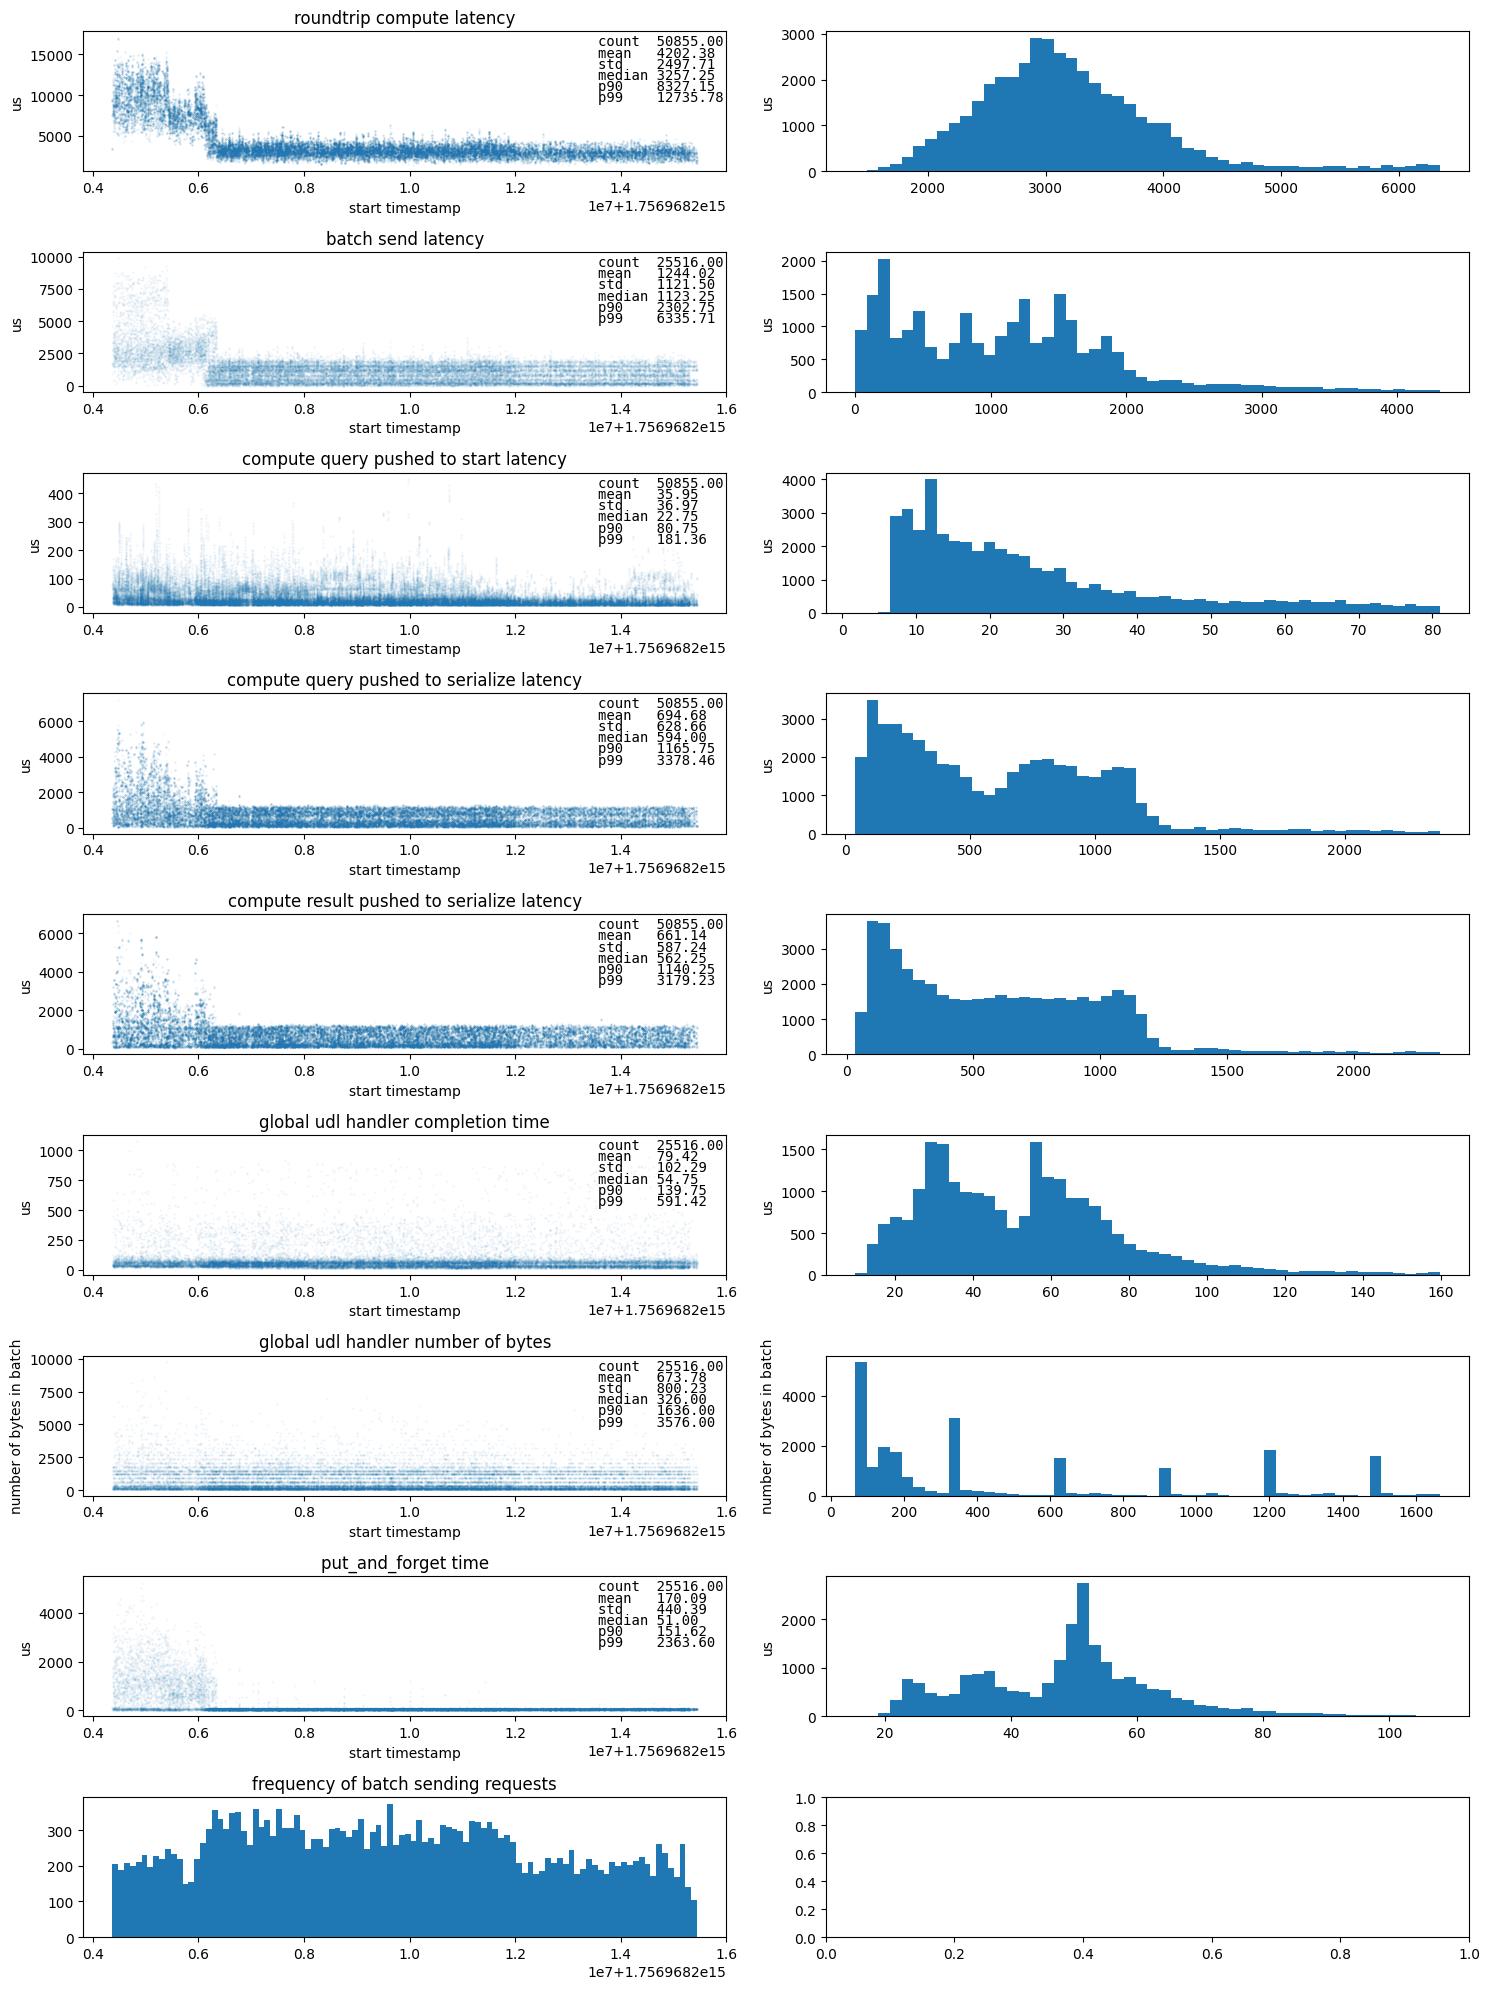

In [61]:
graph_data_from_log_files(remote_rdma_test_compute_pipeline_data_folder, "grid_rdma_test_compute_pipeline.png")

number of existing batch id 862087
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50711
mean:  6751.089595945653
std:  7112.885462274187
90p:   10781.0
99p:  33955.525
compute query duration from send request to start of serialization of that batch on batching thread
count 50711
mean:  693.5103133442449
std:  646.4738166102577
90p:   1189.75
99p:  3389.5500000000065
batch serialization time between udls for global search
count 33696
mean:  9.344076448243115
std:  4.561817661056608
90p:   12.25
99p:  22.0
batch sending latency between udls for global search
num_malformed 1
count 33696
mean:  2093.722311253561
std:  1468.3520949807269
90p:   4082.125
99p:  6191.92500000001
time to complete a put_and_forget
count 33696
mean:  179.46790420227921
std:  440.36560304676357
90p:   480.375
99p:  2341.2625000000007
time to transfer messages from cluster messages to to_send
count 30745
mean:  46.58468856724671
std:  11.904688916150416
90p:   5

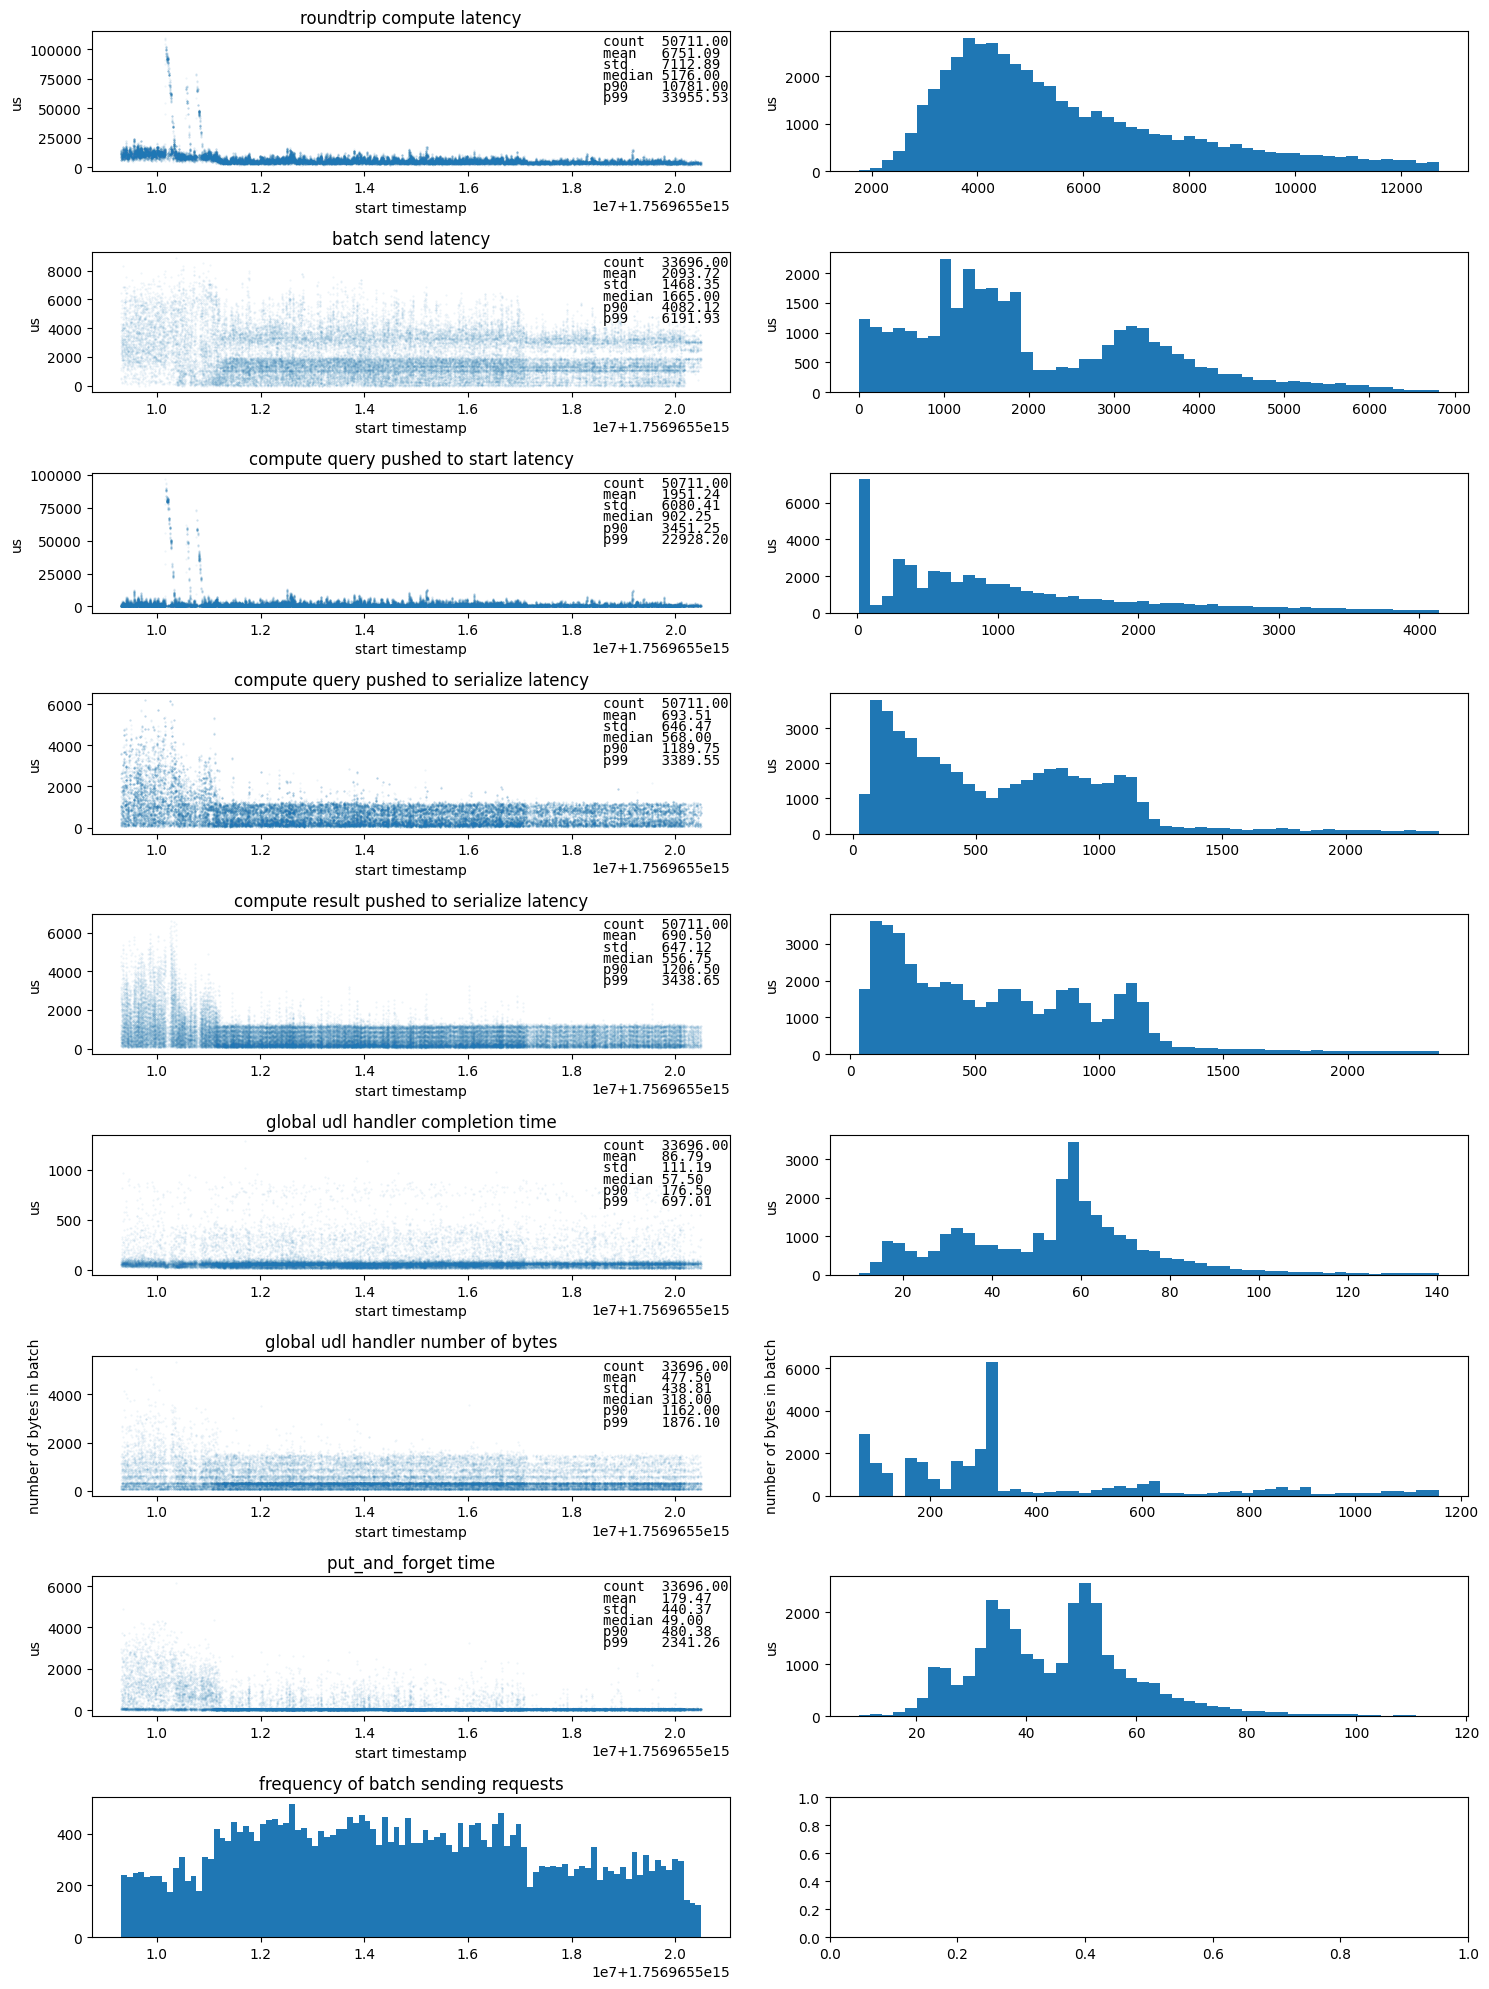

In [62]:
graph_data_from_log_files(remote_rdma_baseline_data_folder, "grid_rdma_baseline.png")

number of existing batch id 457695
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50855
mean:  4322.421753023302
std:  2616.0680373629375
90p:   8302.15
99p:  13705.899999999998
compute query duration from send request to start of serialization of that batch on batching thread
count 50855
mean:  686.5375331825779
std:  608.7348523684067
90p:   1164.1499999999996
99p:  3191.115
batch serialization time between udls for global search
count 25444
mean:  9.95833988366609
std:  4.7267967593624025
90p:   12.25
99p:  22.0
batch sending latency between udls for global search
num_malformed 1
count 25444
mean:  2311.855820625688
std:  1626.4575107079158
90p:   4176.925
99p:  8826.202499999998
time to complete a put_and_forget
count 25444
mean:  177.56928941990253
std:  459.0669327044786
90p:   178.75
99p:  2460.5324999999993
time to transfer messages from cluster messages to to_send
count 23902
mean:  49.5635093297632
std:  11.191385838034126

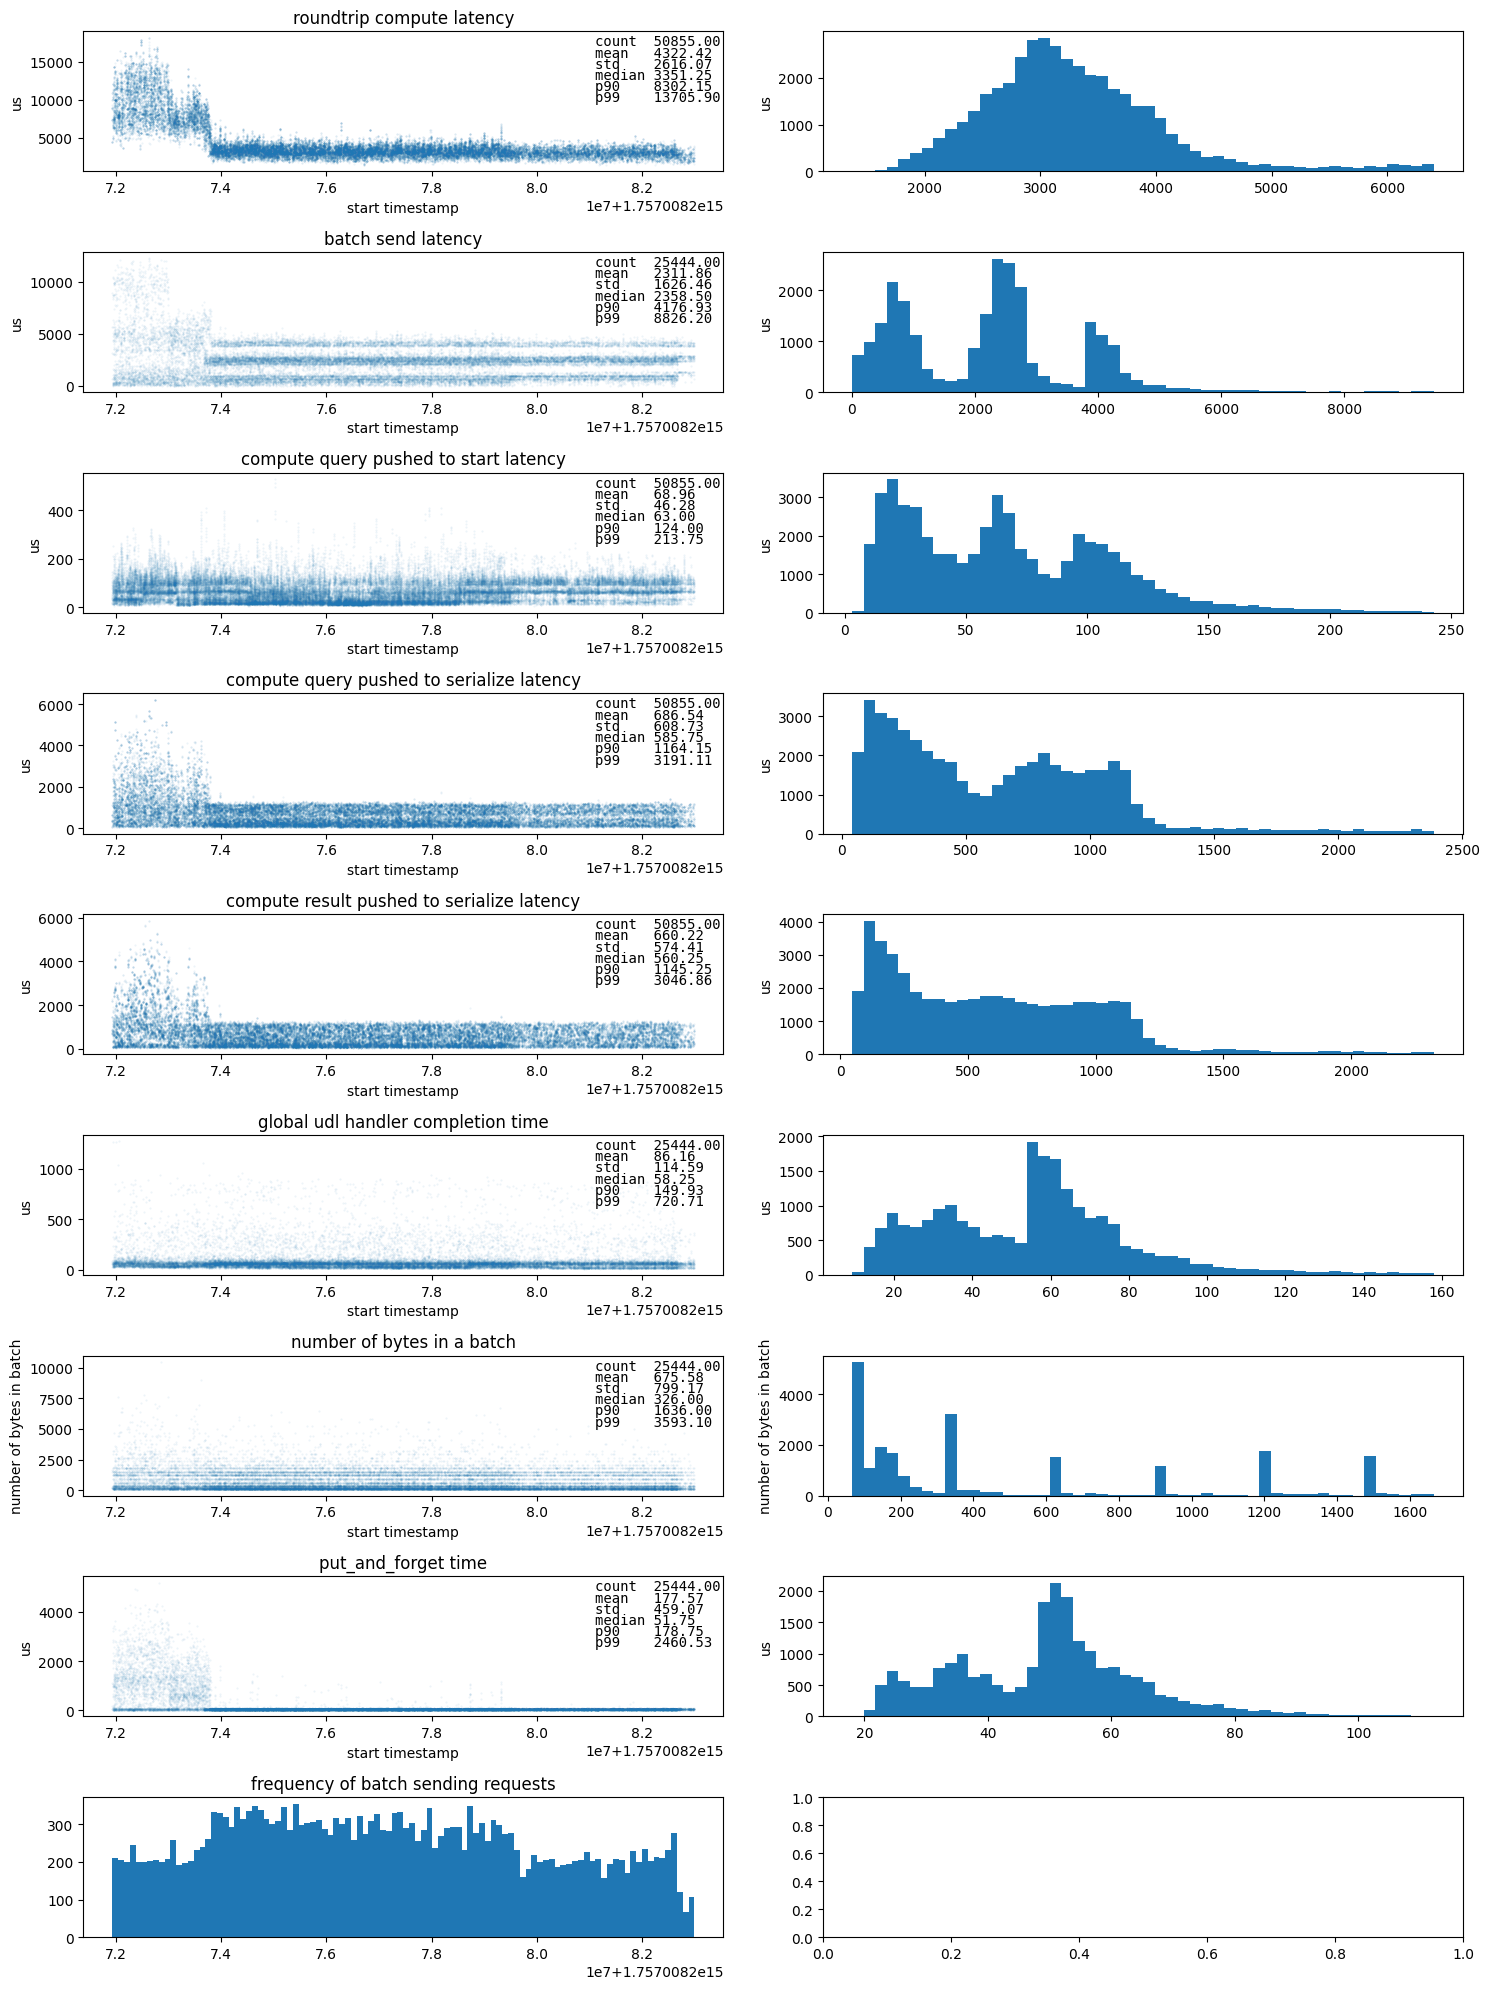

In [65]:
graph_data_from_log_files(remote_rdma_test_compute_pipeline_global_handler, "grid_rdma_test_compute_pipeline_global_handler.png")

number of existing batch id 861985
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50705
mean:  7111.767577162015
std:  8049.417691896294
90p:   11300.649999999998
99p:  48284.71999999999
compute query duration from send request to start of serialization of that batch on batching thread
count 50705
mean:  688.0160240607435
std:  630.1507725547107
90p:   1178.75
99p:  3371.209999999999
batch serialization time between udls for global search
count 33840
mean:  9.23806146572104
std:  4.496165845371555
90p:   12.25
99p:  22.25
batch sending latency between udls for global search
num_malformed 1
count 33840
mean:  2209.5637189716313
std:  1626.6161880571603
90p:   4154.75
99p:  7751.557500000006
time to complete a put_and_forget
count 33840
mean:  187.18525413711583
std:  445.9583689461894
90p:   552.8000000000011
99p:  2336.720000000001
time to transfer messages from cluster messages to to_send
count 30939
mean:  46.01641132551149
std:  

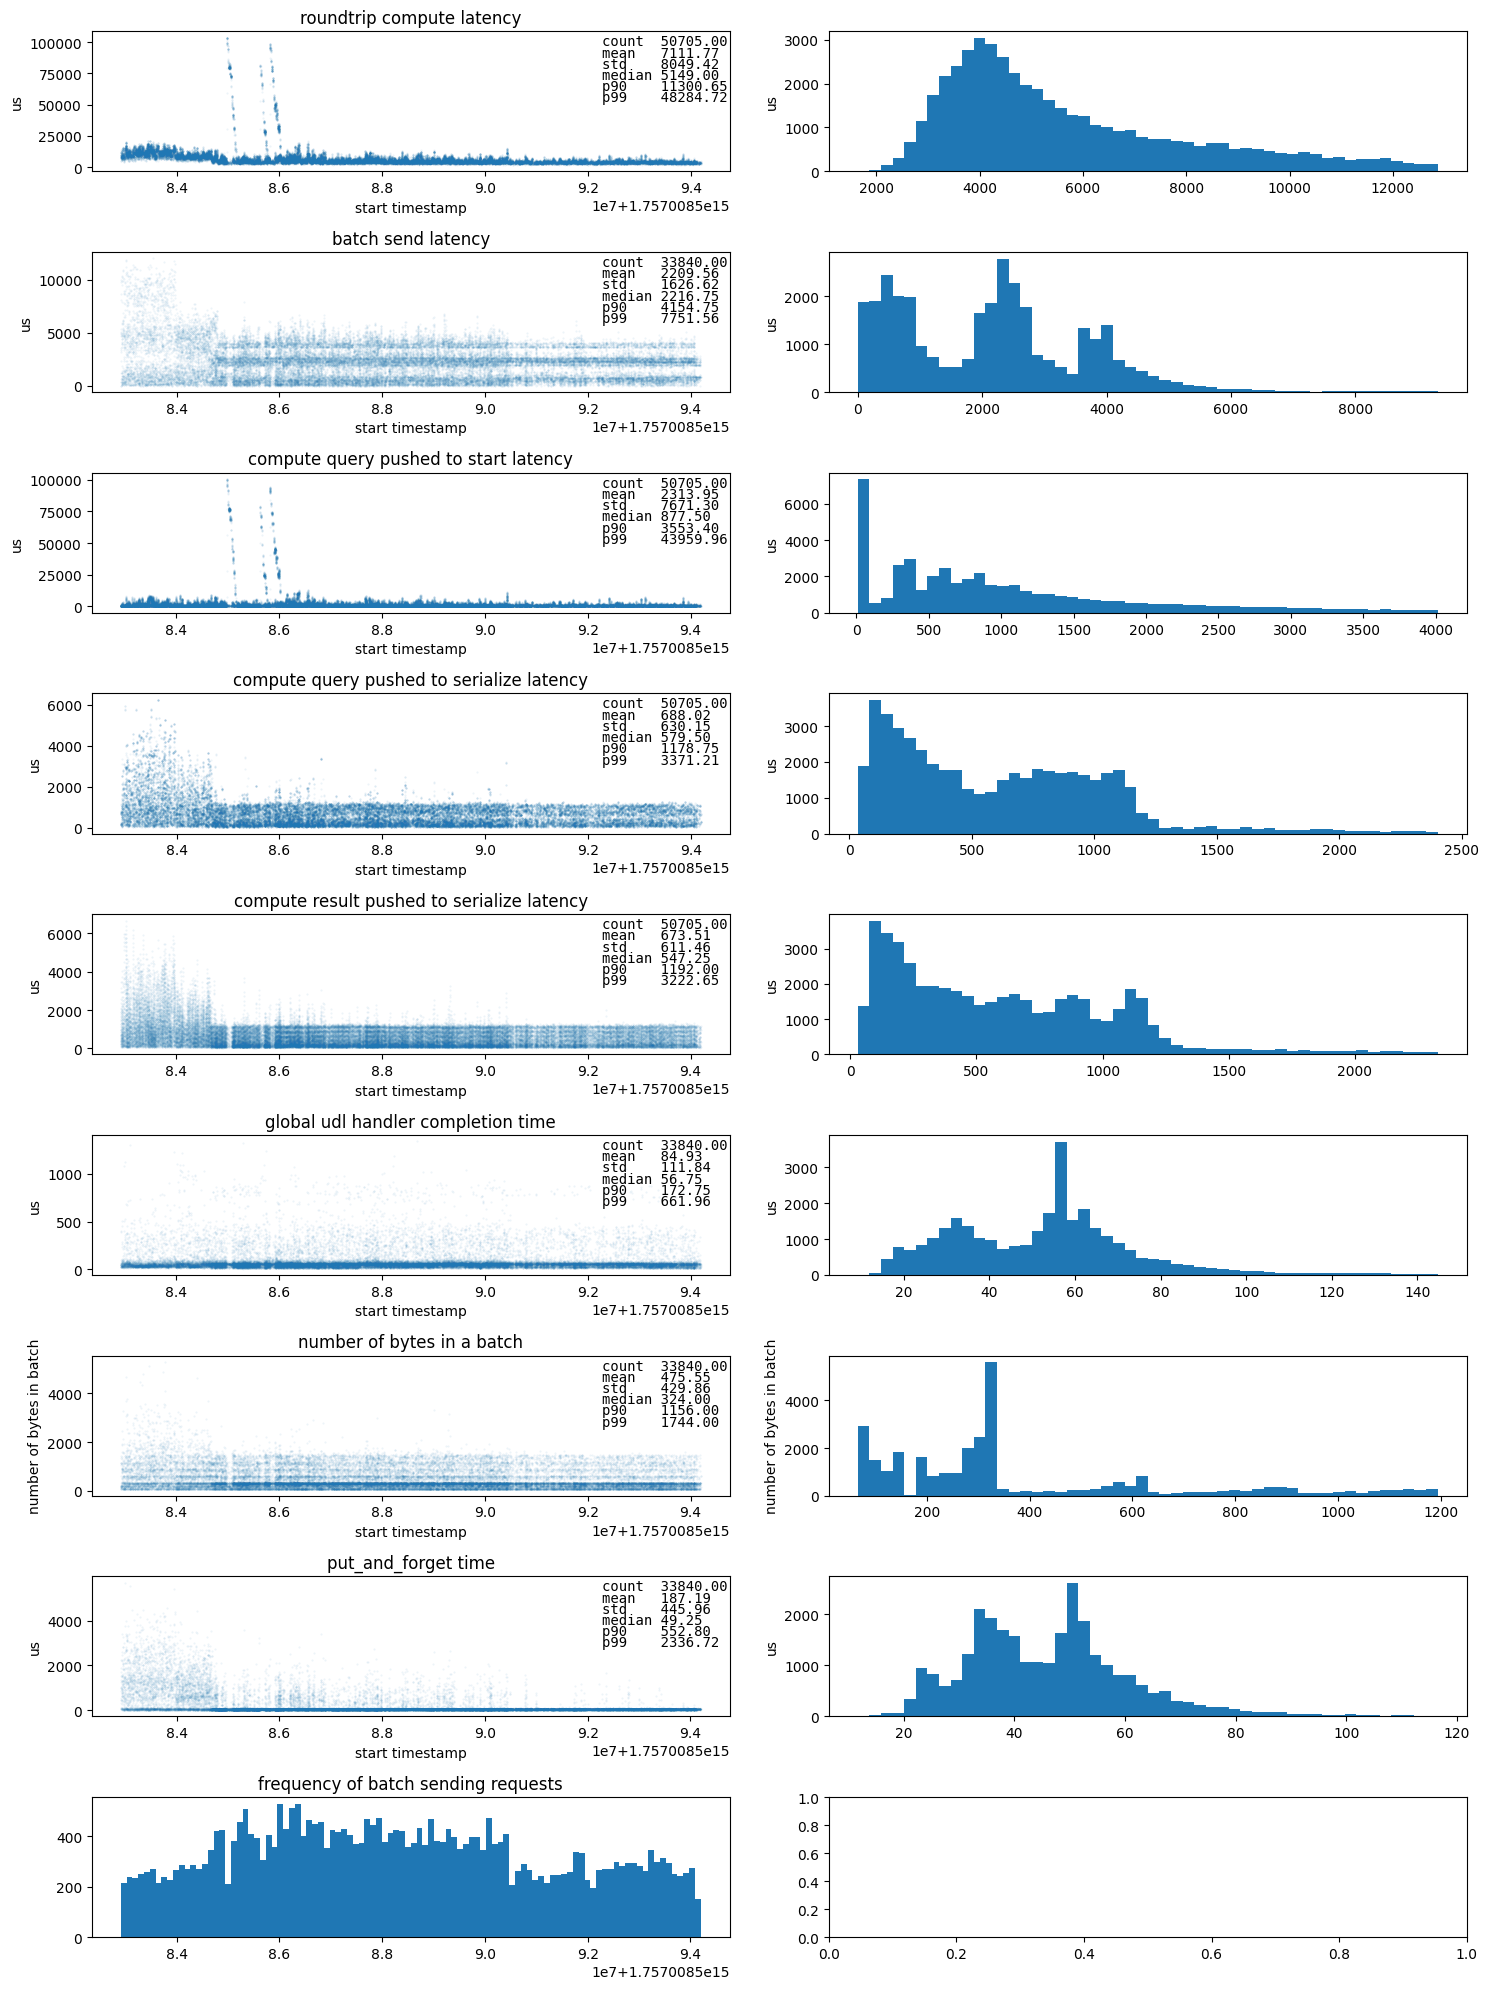

In [66]:
graph_data_from_log_files(remote_rdma_test_global_handler, "grid_rdma_test_global_handler.png")

number of existing batch id 457479
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50831
mean:  4337.17360960831
std:  2467.5678654926683
90p:   8234.5
99p:  13142.349999999999
compute query duration from send request to start of serialization of that batch on batching thread
count 50831
mean:  688.7554986130511
std:  599.4983266015305
90p:   1164.75
99p:  3145.8249999999935
batch serialization time between udls for global search
count 25473
mean:  10.02078671534566
std:  3.931029412737321
90p:   12.5
99p:  23.0
batch sending latency between udls for global search
num_malformed 1
count 25473
mean:  2191.6568130962196
std:  1634.734967659545
90p:   4071.5
99p:  8661.549999999981
time to complete a put_and_forget
count 25473
mean:  178.85199034271582
std:  452.06114345673365
90p:   317.5499999999993
99p:  2386.8099999999977
time to transfer messages from cluster messages to to_send
count 23888
mean:  50.00268963496316
std:  13.12741576

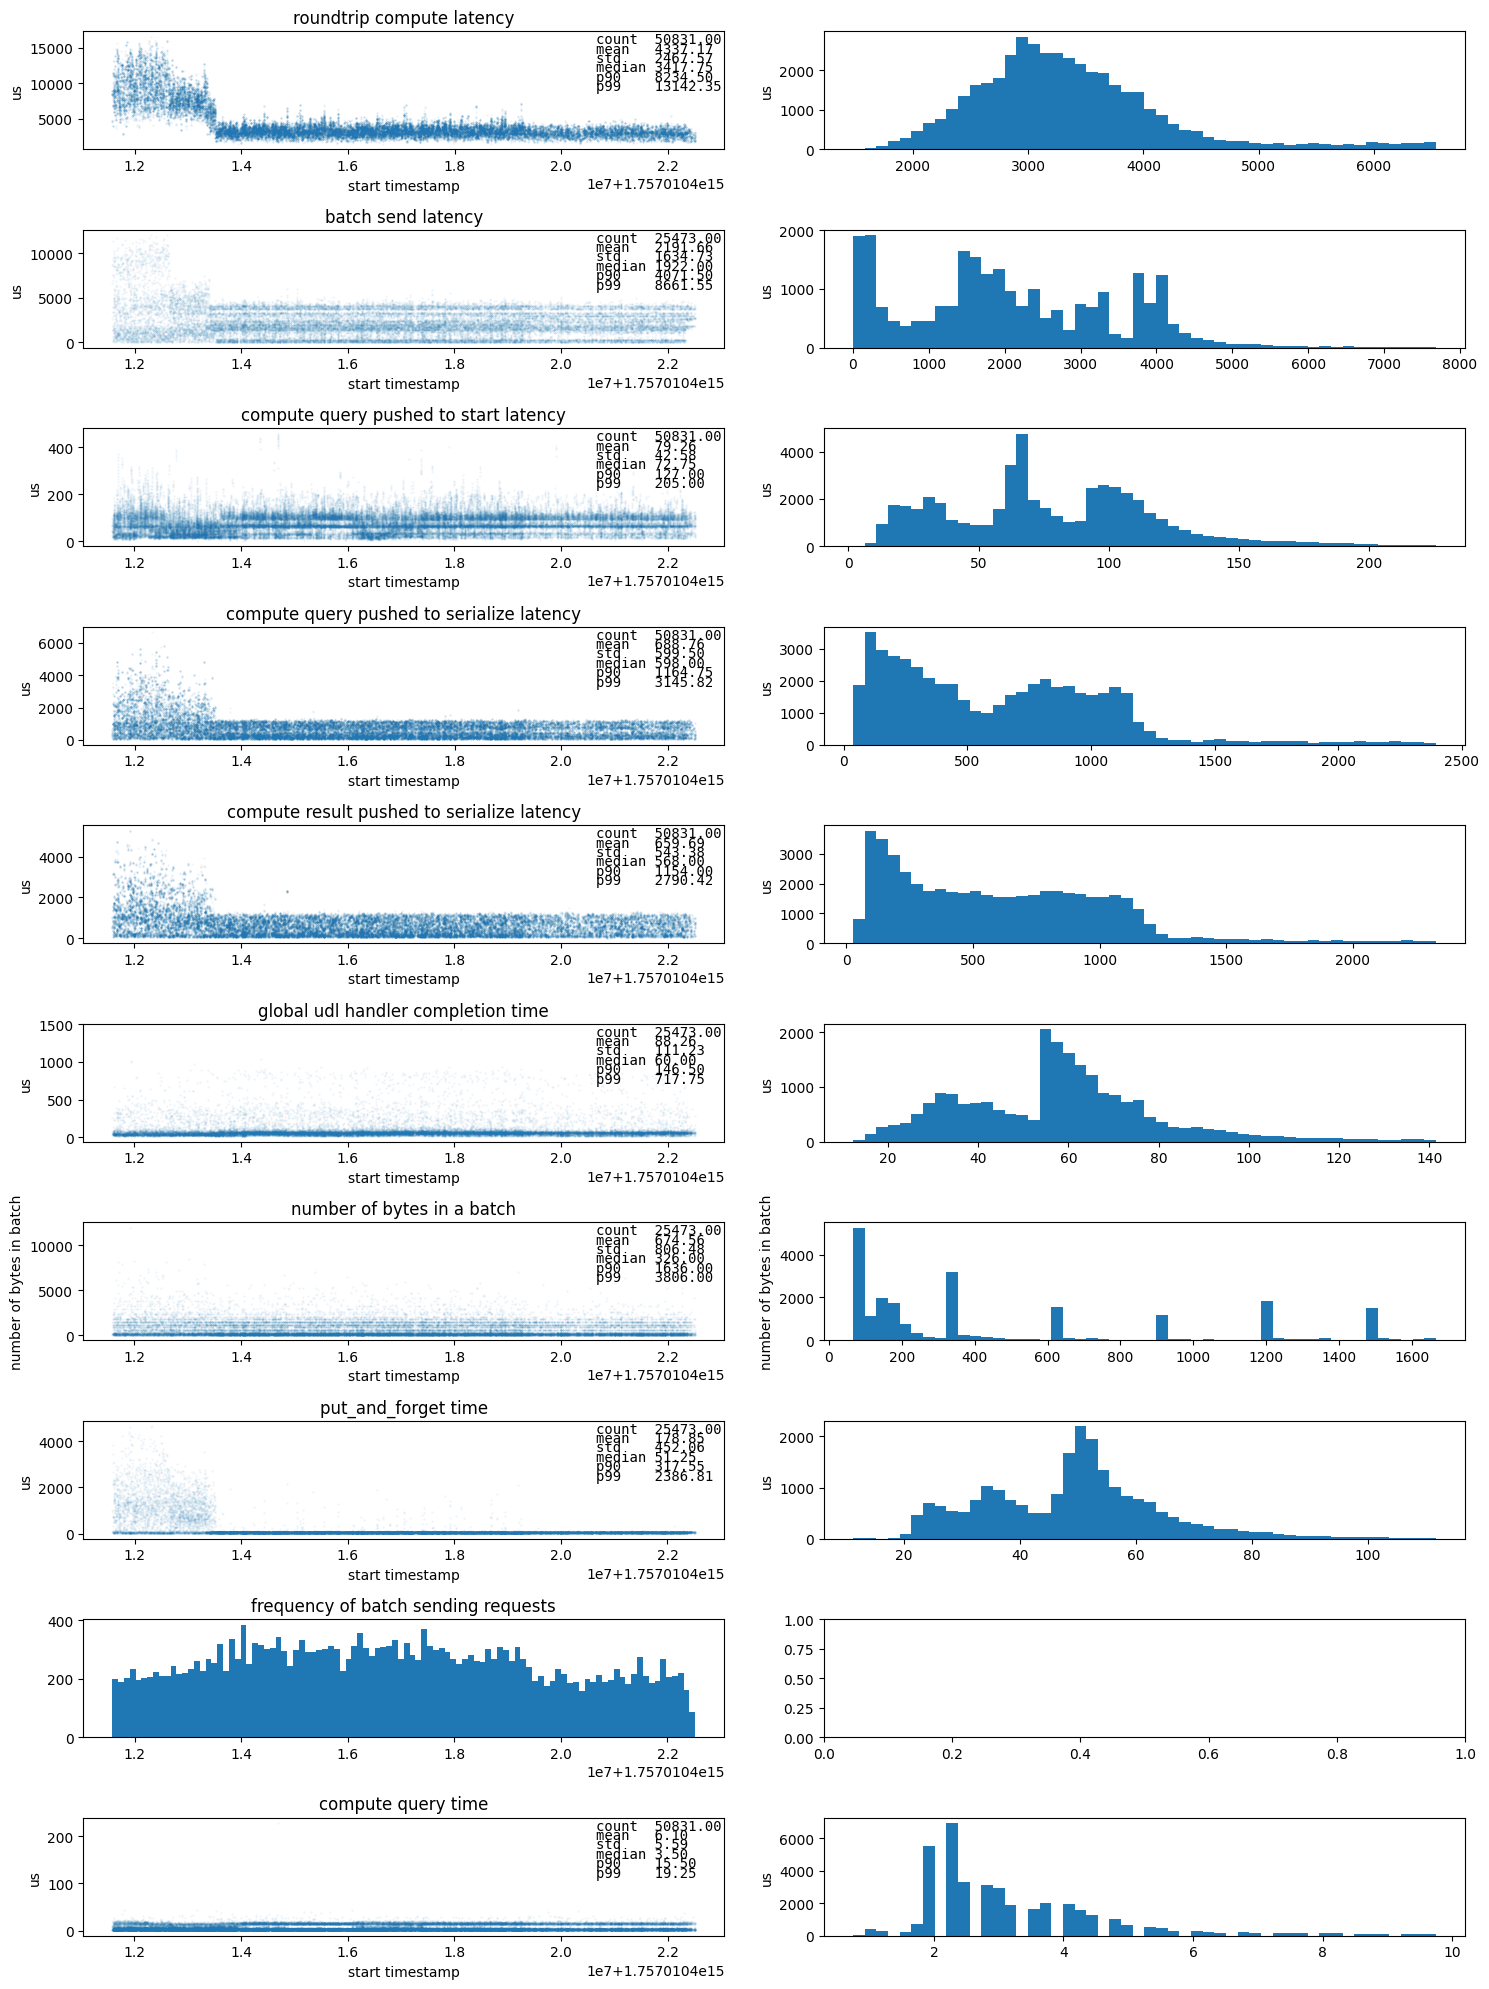

In [71]:
graph_data_from_log_files(remote_rdma_test_compute_pipeline_again, "grid_rdma_test_compute_pipeline_again.png")

number of existing batch id 861951
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50703
mean:  6056.51969804548
std:  3361.7473688441955
90p:   10417.300000000003
99p:  16618.324999999964
compute query duration from send request to start of serialization of that batch on batching thread
count 50703
mean:  686.4151332268308
std:  619.697999105712
90p:   1184.25
99p:  3236.6299999999756
batch serialization time between udls for global search
count 33771
mean:  9.083355541736994
std:  3.9303181706341093
90p:   12.25
99p:  21.5
batch sending latency between udls for global search
num_malformed 1
count 33771
mean:  1426.5202022445294
std:  1117.85679098097
90p:   2598.5
99p:  6152.125000000047
time to complete a put_and_forget
count 33771
mean:  180.263258416985
std:  442.87848421904494
90p:   482.75
99p:  2377.9750000000167
time to transfer messages from cluster messages to to_send
count 30873
mean:  45.75367635150455
std:  12.056084700

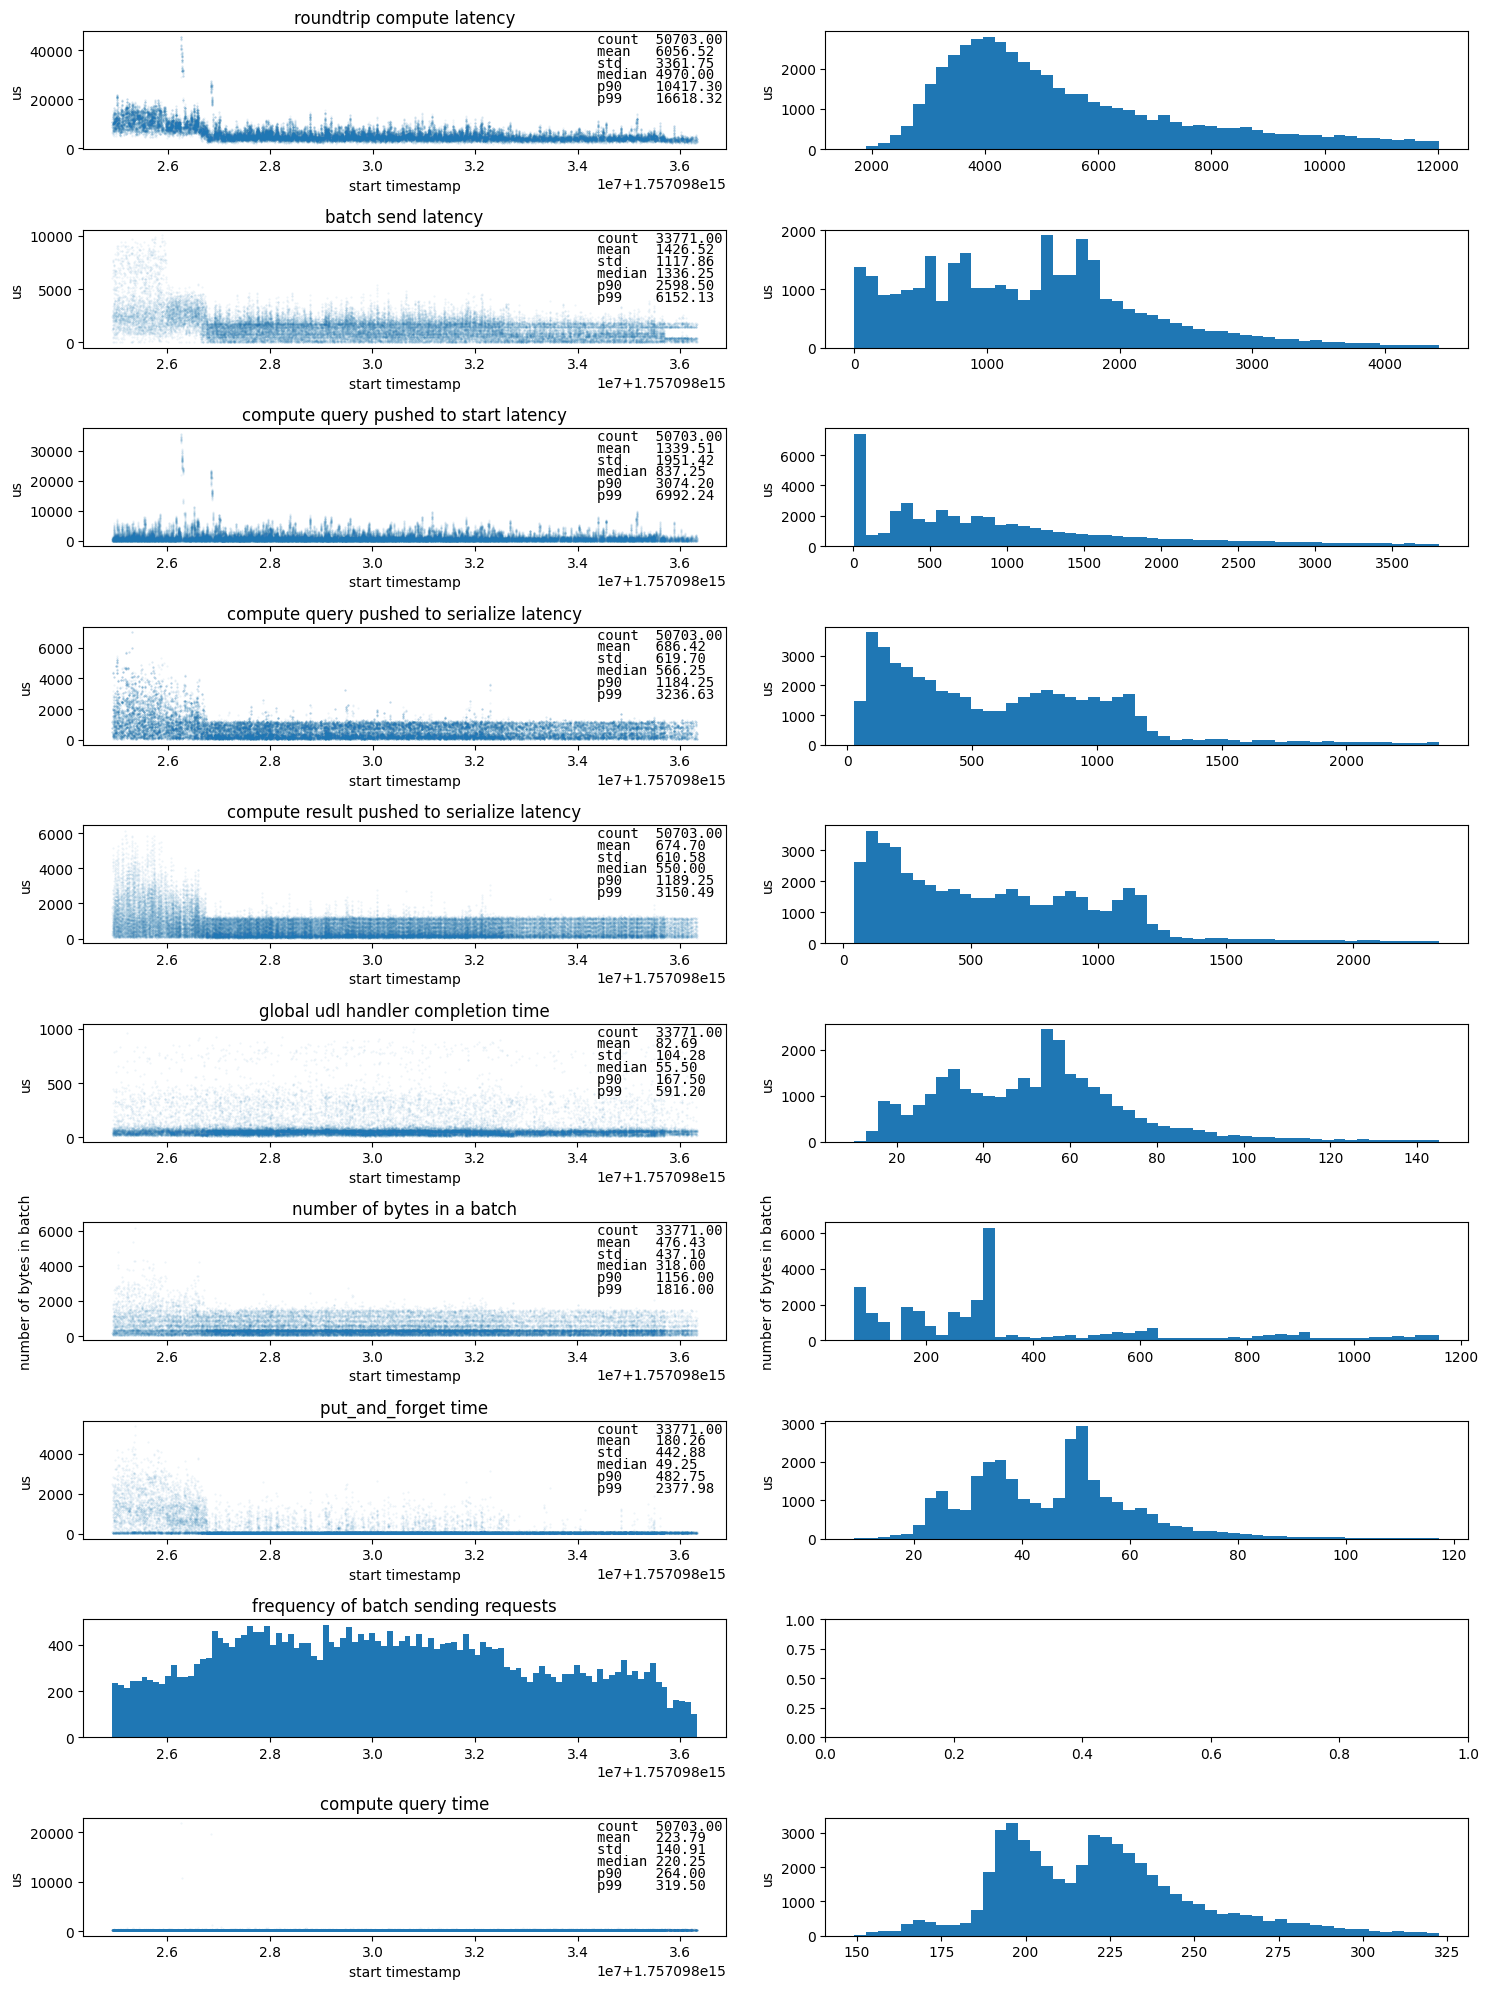

In [83]:
graph_data_from_log_files("/home/nam/workspace/rdma_anns/remote_data/rdma/baseline_again", "grid_rdma_baseline_again.png")

number of existing batch id 457002
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50778
mean:  4362.7437423687425
std:  2524.34544479062
90p:   8314.825
99p:  13267.307499999999
compute query duration from send request to start of serialization of that batch on batching thread
count 50778
mean:  683.2223650005908
std:  599.7048523444115
90p:   1176.75
99p:  3142.307499999999
batch serialization time between udls for global search
count 25010
mean:  9.999460215913635
std:  4.584280105299675
90p:   12.25
99p:  22.25
batch sending latency between udls for global search
num_malformed 1
count 25010
mean:  1322.5330067972811
std:  1145.4713689519106
90p:   2405.7750000000005
99p:  6654.48
time to complete a put_and_forget
count 25010
mean:  184.30707716913236
std:  454.0978809046949
90p:   442.5
99p:  2373.9325
time to transfer messages from cluster messages to to_send
count 23551
mean:  49.475234597257014
std:  11.970542831139197
90p:   

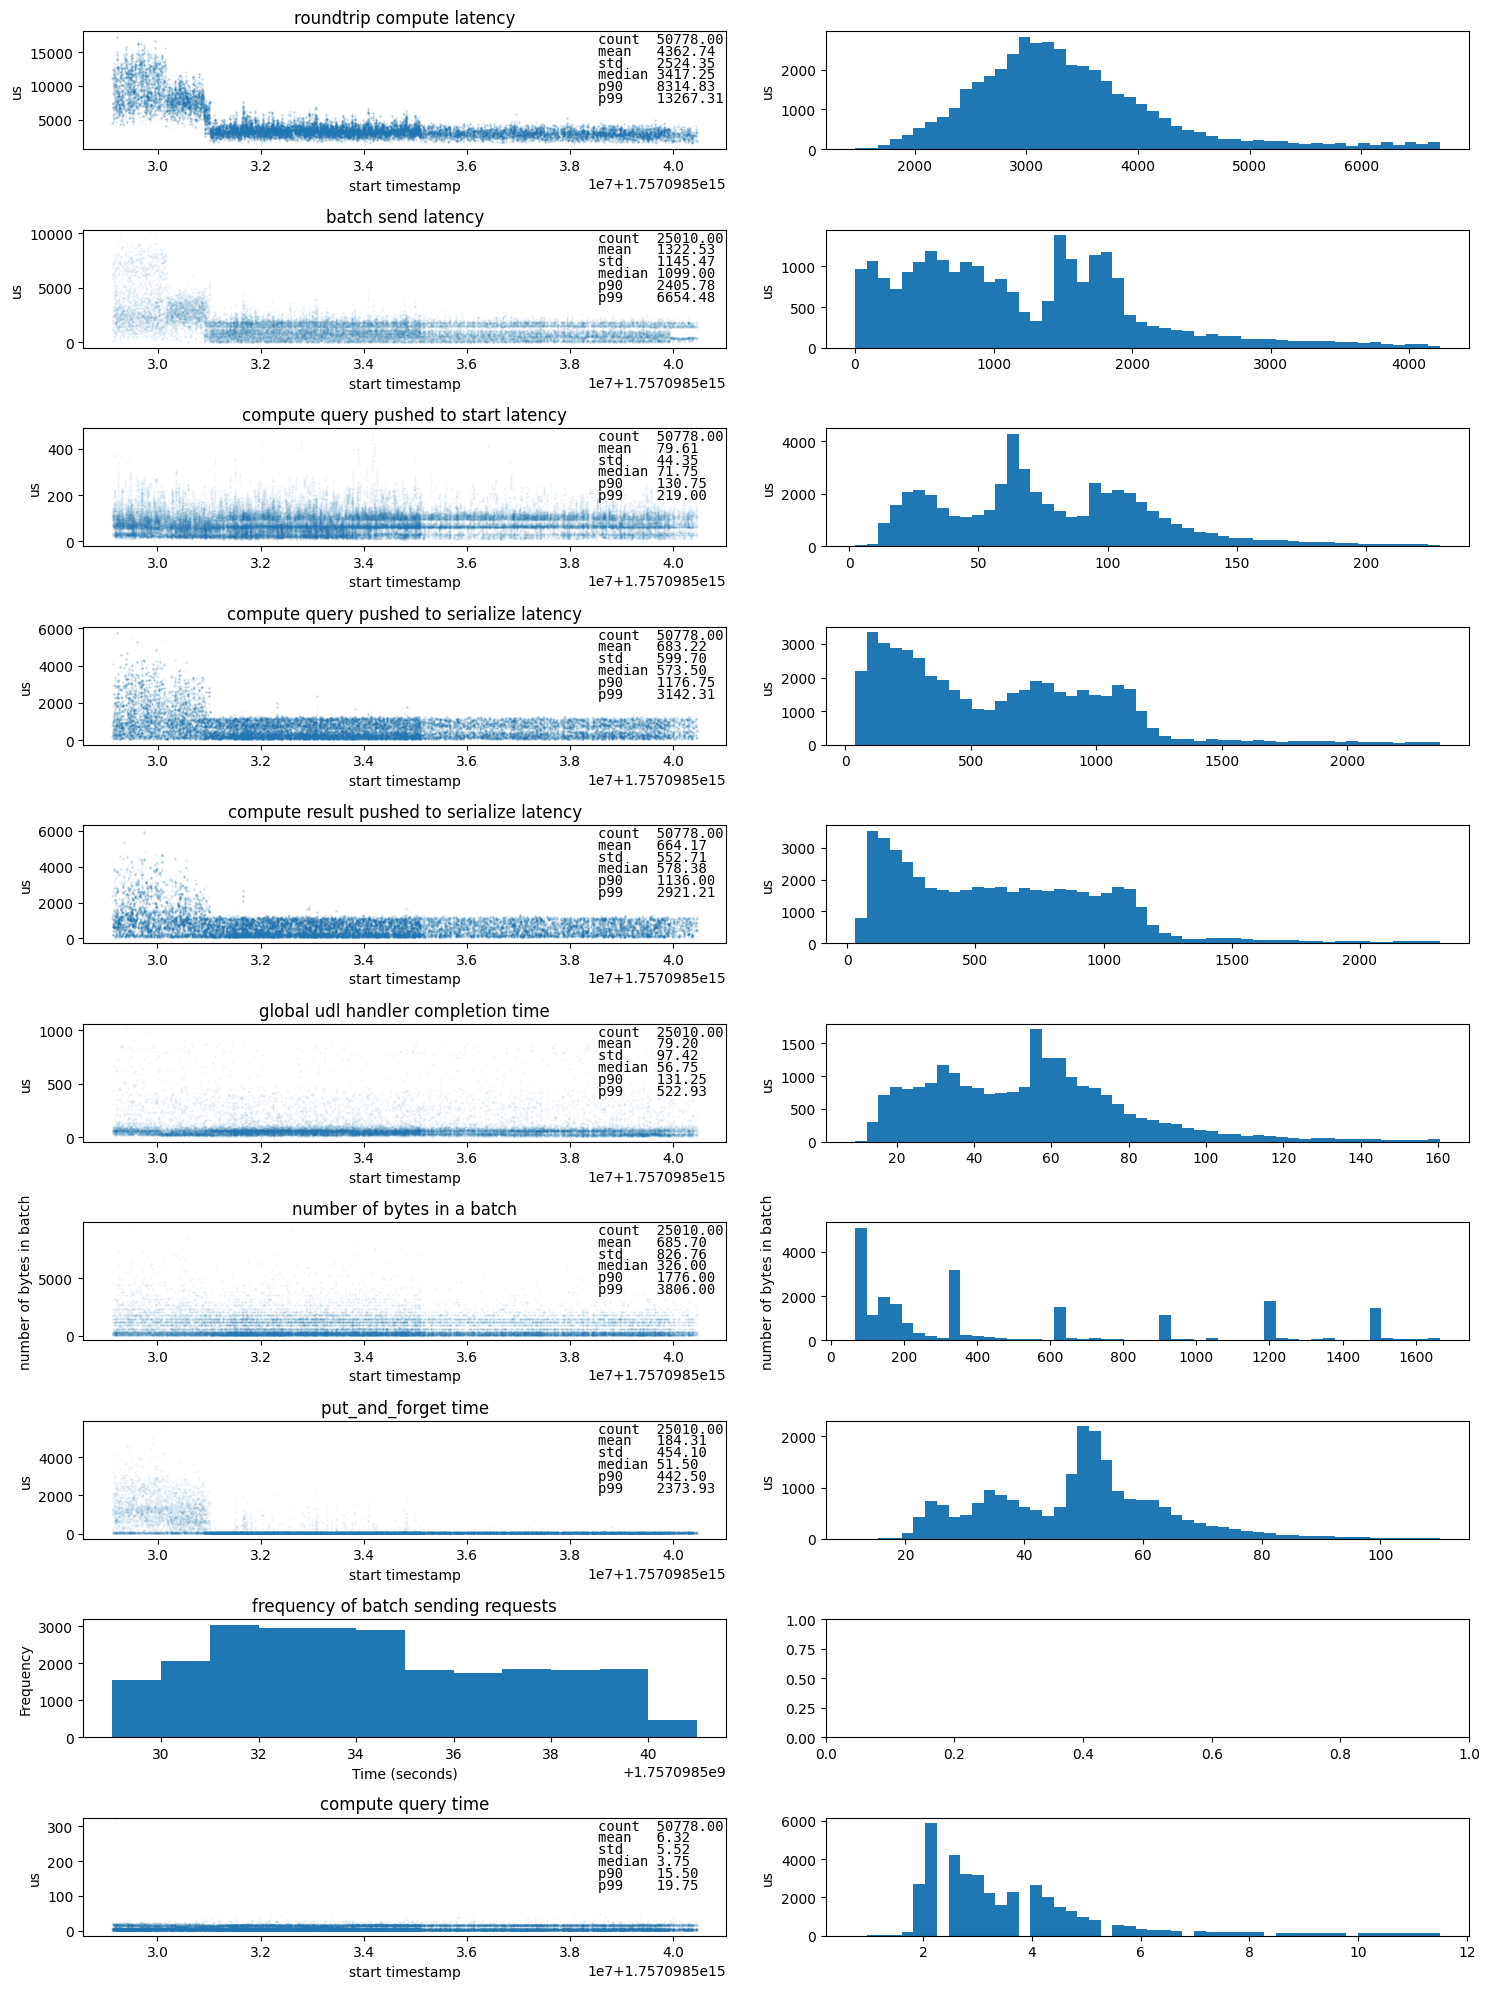

In [95]:
graph_data_from_log_files("/home/nam/workspace/rdma_anns/remote_data/rdma/test_compute_pipeline_again_1/", "grid_rdma_test_compute_pipeline_again_1.png")

number of existing batch id 862342
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50726
mean:  6667.747323857588
std:  7544.218146178117
90p:   10578.125
99p:  43972.0
compute query duration from send request to start of serialization of that batch on batching thread
count 50726
mean:  687.5975880219218
std:  651.0727775244209
90p:   1161.5
99p:  3530.8125
batch serialization time between udls for global search
count 32729
mean:  8.263550673714443
std:  4.127274286477294
90p:   12.25
99p:  21.0
batch sending latency between udls for global search
num_malformed 1
count 32729
mean:  1427.2074612728773
std:  1097.3463497353225
90p:   2671.5
99p:  5942.9100000000035
time to complete a put_and_forget
count 32729
mean:  173.25090897980385
std:  439.7680784063843
90p:   475.2000000000007
99p:  2316.0000000000073
time to transfer messages from cluster messages to to_send
count 29740
mean:  41.92679892400807
std:  13.095849660486218
90p:   5

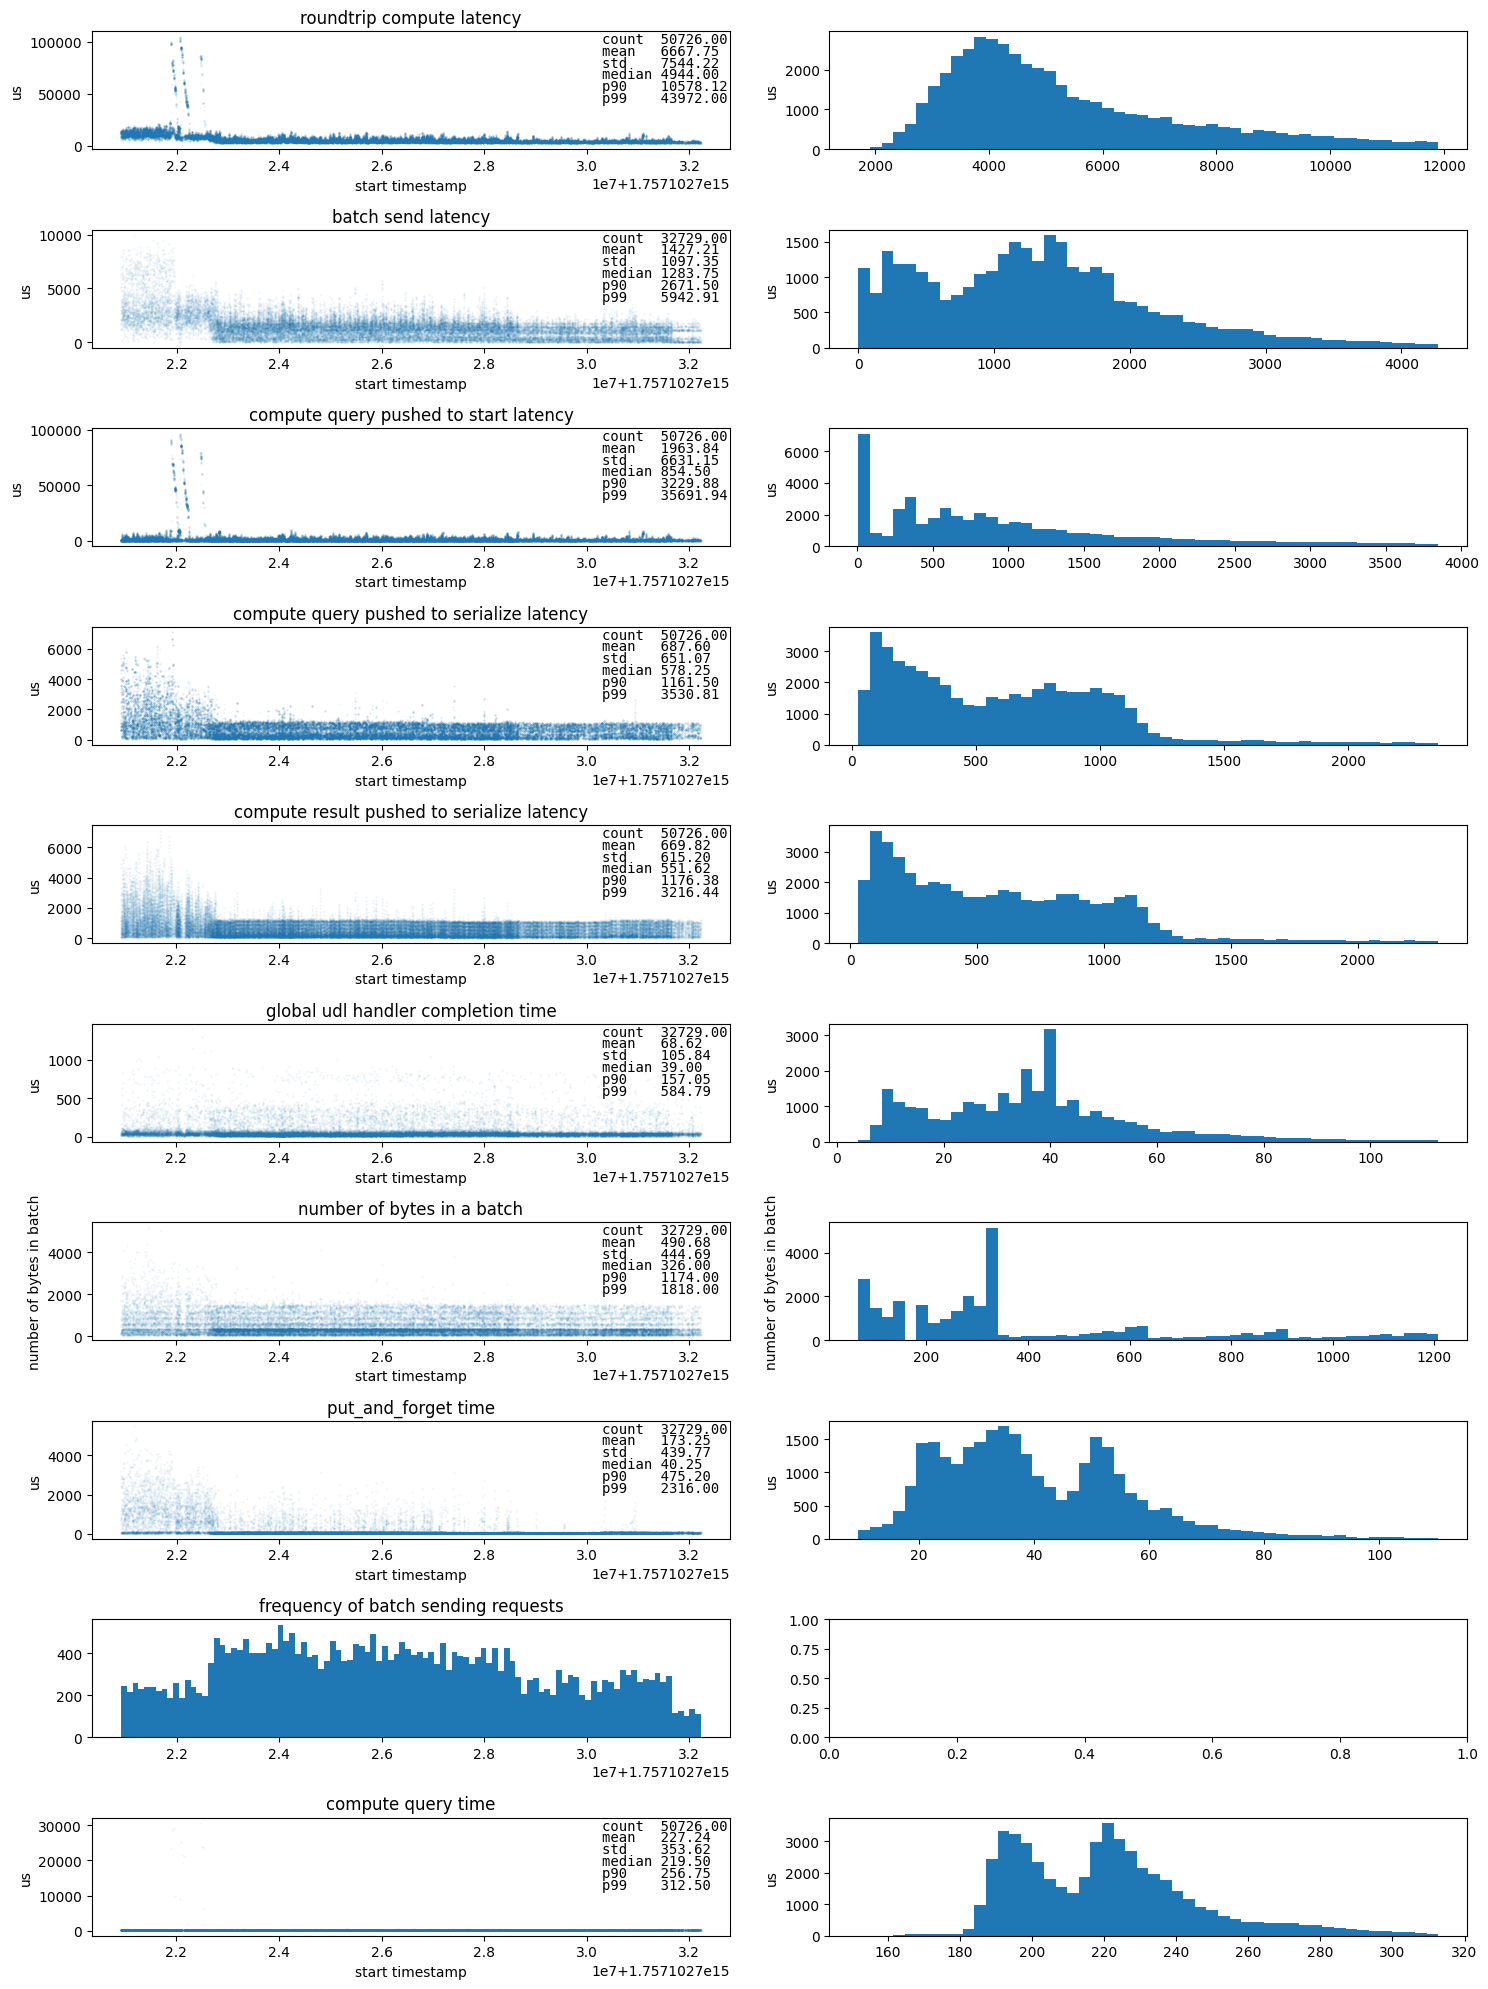

In [84]:
graph_data_from_log_files("/home/nam/workspace/rdma_anns/remote_data/rdma/baseline_optimized_udl_handler", "grid_rdma_test_compute_pipeline_again_1.png")

number of existing batch id 862189
No conflicts - all existing batch_ids match the dictionary
round trip latency of compute query
count 50717
mean:  6917.4238322455985
std:  7672.846948355038
90p:   11302.95
99p:  51435.07999999963
compute query duration from send request to start of serialization of that batch on batching thread
count 50717
mean:  708.8259853697971
std:  679.4880362161571
90p:   1216.25
99p:  3653.179999999993
batch serialization time between udls for global search
count 33946
mean:  9.223973369469157
std:  3.887853834402268
90p:   12.25
99p:  22.25
batch sending latency between udls for global search
num_malformed 1
count 33946
mean:  1871.28744181936
std:  1479.7405495442688
90p:   3531.125
99p:  7457.912500000002
time to complete a put_and_forget
count 33946
mean:  182.14784510693454
std:  450.62921207421914
90p:   490.75
99p:  2369.2750000000015
time to transfer messages from cluster messages to to_send
count 30638
mean:  46.82884816241269
std:  12.357538497328264

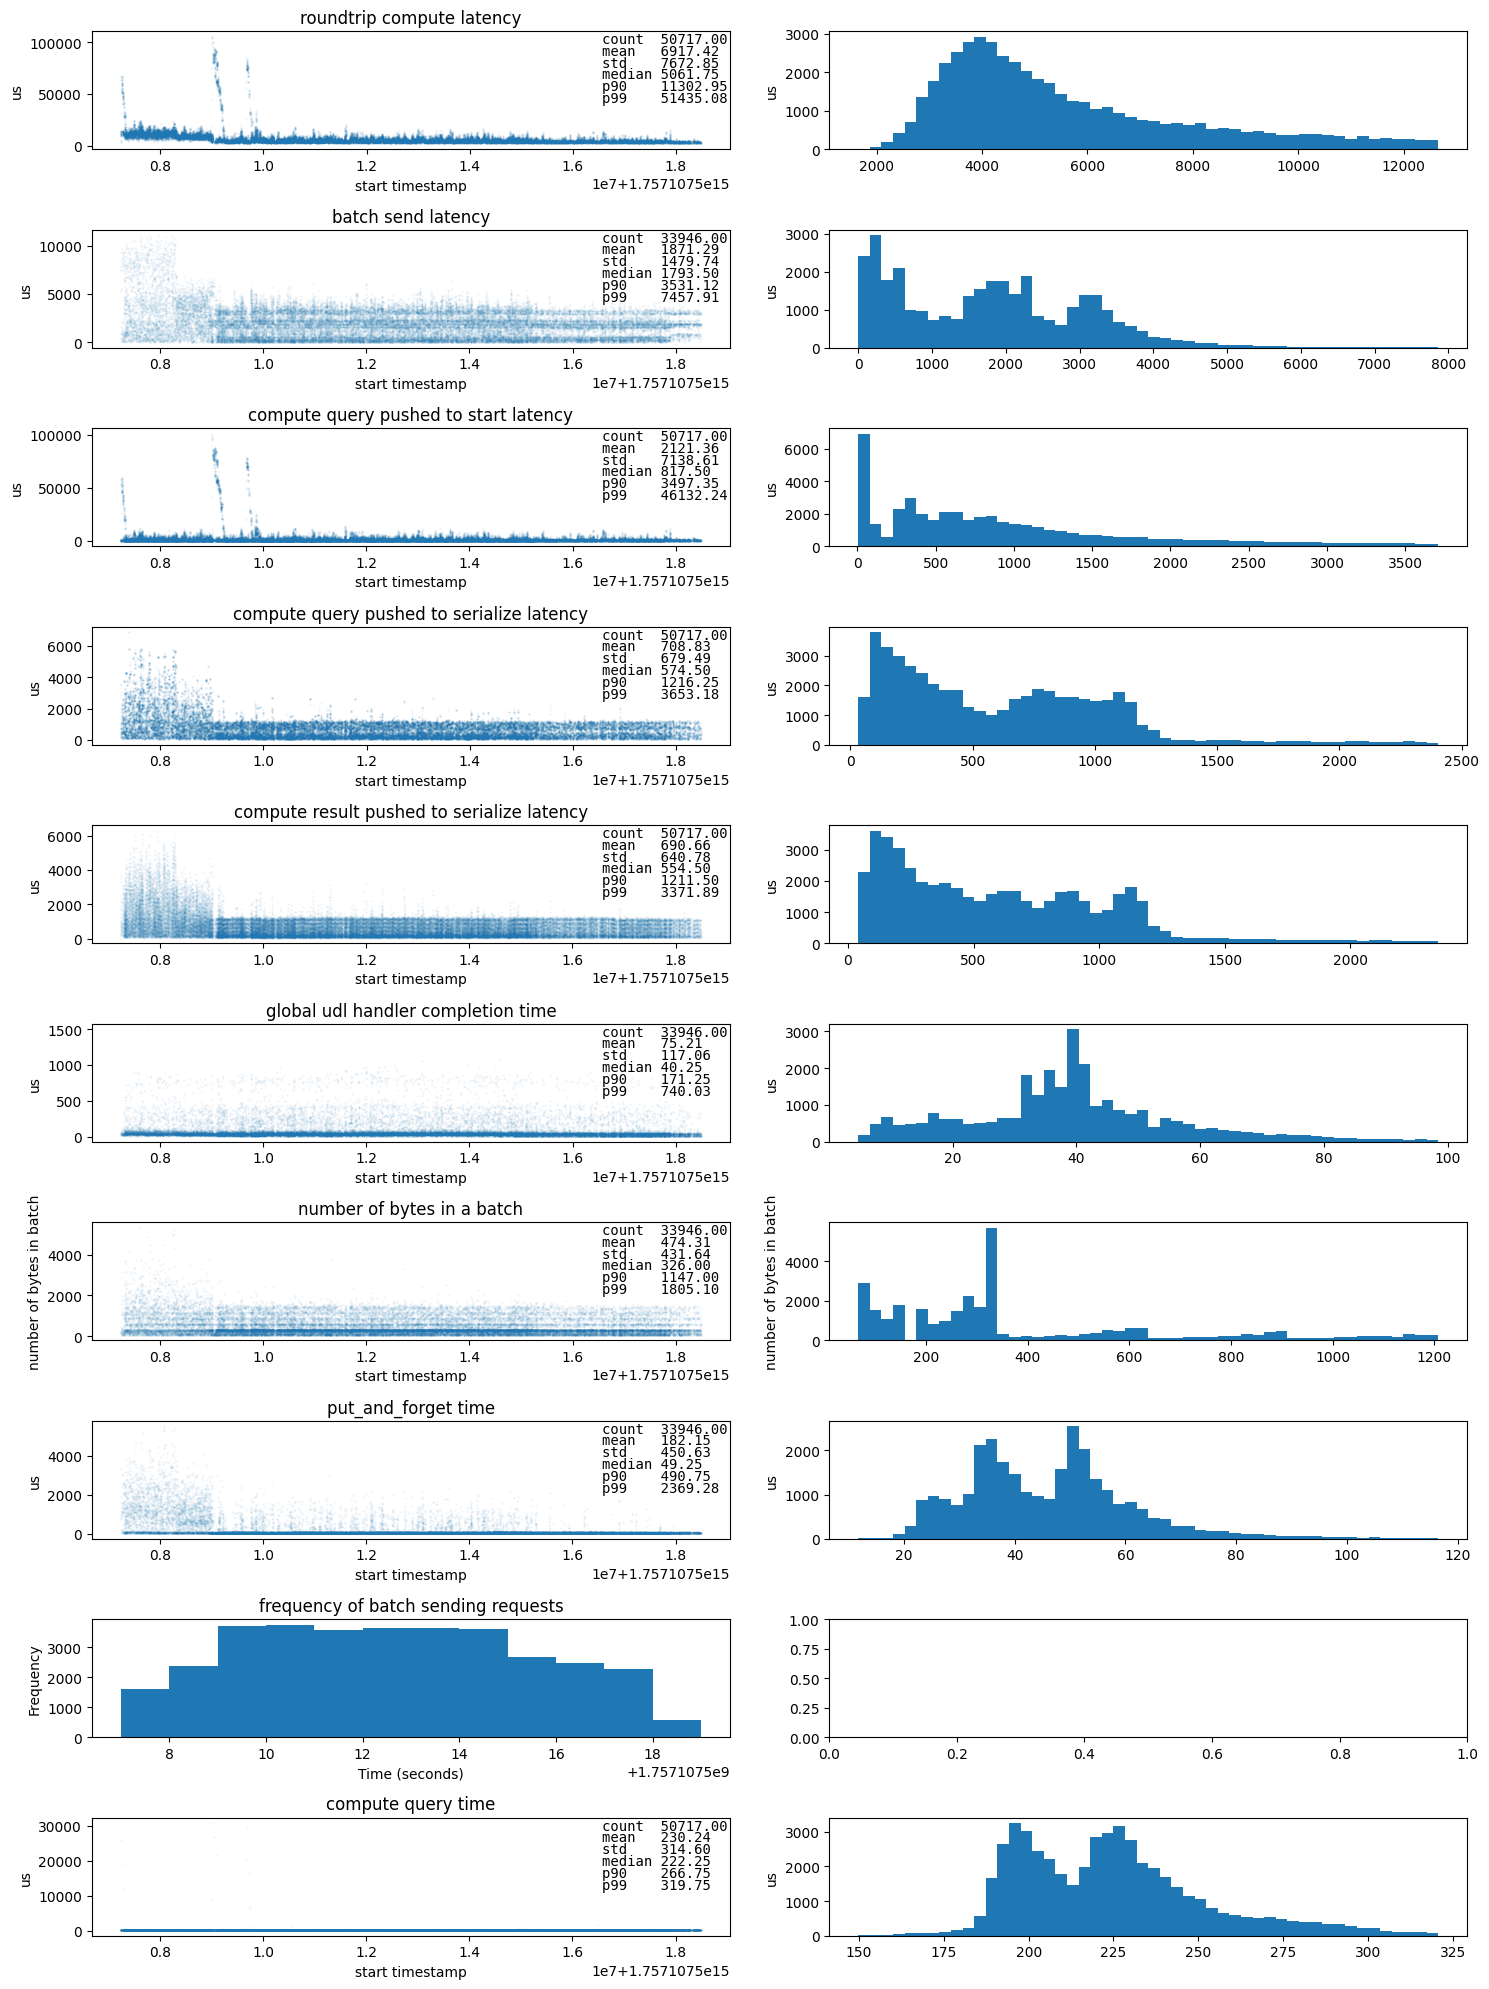

In [94]:
graph_data_from_log_files("/home/nam/workspace/rdma_anns/remote_data/rdma/baseline_optimized_udl_handler", "grid_rdma_test_compute_pipeline_again_1.png")